In [31]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Function to load images from a given folder and assign labels based on the file name convention
def load_images(path_to_images, label):
    images = []
    labels = []
    for filename in os.listdir(path_to_images):
        if filename.endswith(".png"):  # assuming your images are in jpg format
            img = cv2.imread(os.path.join(path_to_images, filename), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (255, 255))  # resizing to normalize size
            images.append(img.flatten())  # flattening the image to a 1D array
            labels.append(label)  # using the given label for all images in this folder
    return images, labels

# Load datasets
black_images, black_labels = load_images('/Users/farhanrashid/Downloads/Mugshot V3/Black Offender', label=1)
non_black_images, non_black_labels = load_images('/Users/farhanrashid/Downloads/Mugshot V3/Non-Black Offender', label=0)

# Combine datasets
images = np.array(black_images + non_black_images)
labels = np.array(black_labels + non_black_labels)

# Split datasets into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.25, random_state=42)

# Perform PCA (eigenfaces) on the training data
n_components = 100  # number of eigenfaces
pca = PCA(n_components=n_components, whiten=True).fit(X_train)

# Transform both training and testing data
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Train a classifier (SVM in this case)
clf = SVC(kernel='rbf', class_weight='balanced')
clf.fit(X_train_pca, y_train)

# Predict on the testing set
y_pred = clf.predict(X_test_pca)

# Print the classification report to evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.80      0.84       291
           1       0.68      0.79      0.73       154

    accuracy                           0.80       445
   macro avg       0.78      0.80      0.79       445
weighted avg       0.81      0.80      0.80       445



In [8]:
import os
from joblib import dump

# Directory where you want to save the models
model_dir = '/Users/farhanrashid/Downloads'
os.makedirs(model_dir, exist_ok=True)  # It creates the directory if it does not exist

# Paths for the model files
pca_path = os.path.join(model_dir, 'eigenfaces_pca.joblib')
clf_path = os.path.join(model_dir, 'face_classifier.joblib')

# Assuming 'pca' and 'clf' are your trained PCA and SVM models
dump(pca, pca_path)
dump(clf, clf_path)

# Now the models are saved, and you can use these paths to download them.


['/Users/farhanrashid/Downloads/face_classifier.joblib']

In [16]:
from joblib import load
import cv2
import numpy as np

# Function to load a trained model from a file
def load_model(model_path):
    return load(model_path)

# Function to preprocess and predict the label of a new image
def preprocess_and_predict(image_path, pca, clf):
    # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Check if the image was correctly loaded
    if img is None:
        raise ValueError(f"The image at {image_path} could not be loaded.")
    # Resize the image to 255x255 to match the training data
    img = cv2.resize(img, (255, 255))
    # Flatten the image to a 1D array
    img_flattened = img.flatten().reshape(1, -1)
    # Transform the image using the PCA model
    img_pca = pca.transform(img_flattened)
    # Predict the label of the image using the SVM classifier
    label = clf.predict(img_pca)
    return label

# Replace these paths with the paths to your actual model files
pca_model_path = '/Users/farhanrashid/Downloads/eigenfaces_pca.joblib'
svm_model_path = '//Users/farhanrashid/Downloads/face_classifier.joblib'

# Load the models
pca = load_model(pca_model_path)
clf = load_model(svm_model_path)

# Replace this path with the path to the photo you want to test
test_image_path = '/Users/farhanrashid/Downloads/sd18/sd18/single/f0_p1/01553_1_R.png'  # Make sure to upload the photo and use the correct path

# Predict the label for the new photo
photo_label = preprocess_and_predict(test_image_path, pca, clf)
print(f"The predicted label is: {photo_label[0]}")


The predicted label is: 0


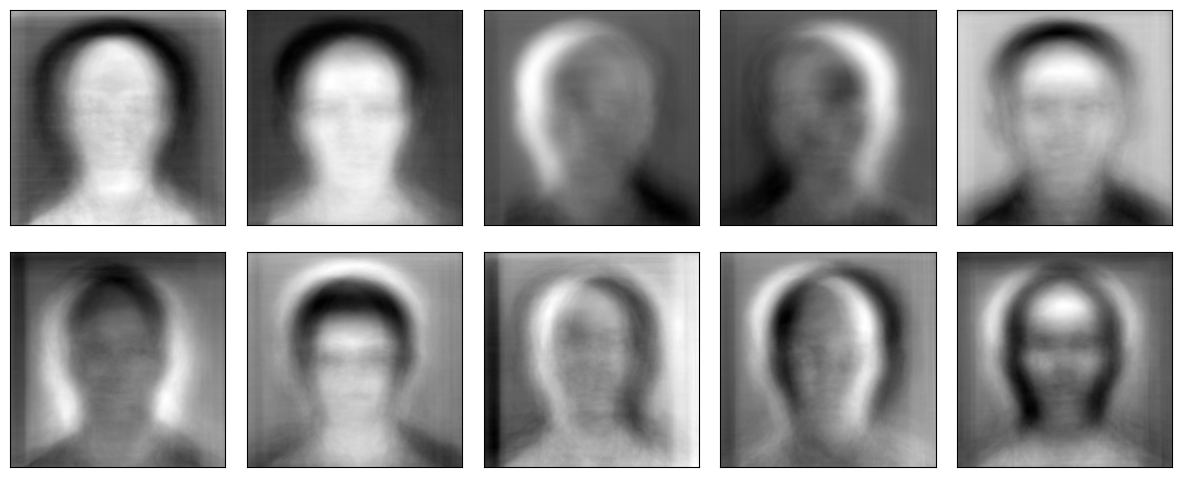

In [32]:
import matplotlib.pyplot as plt

# Assuming `pca` is your PCA object and has been fitted to your data
eigenfaces = pca.components_.reshape((n_components, 255, 255))

# Show the first few eigenfaces
fig, axes = plt.subplots(2, 5, figsize=(15, 6),
                         subplot_kw={'xticks': [], 'yticks': []},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(eigenfaces[i], cmap='gray')
plt.show()


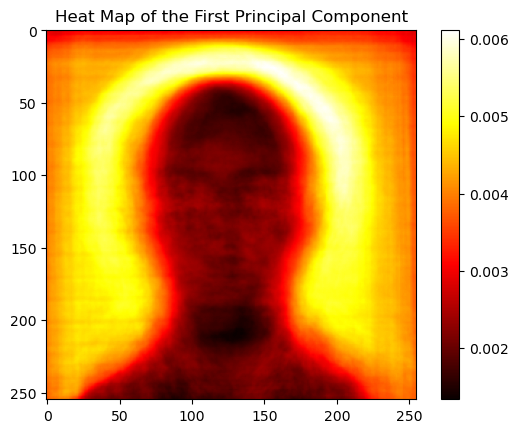

In [33]:
# Visualize the weight of each pixel in the first principal component
plt.imshow(np.abs(pca.components_[0].reshape(255, 255)), cmap='hot')
plt.colorbar()
plt.title("Heat Map of the First Principal Component")
plt.show()


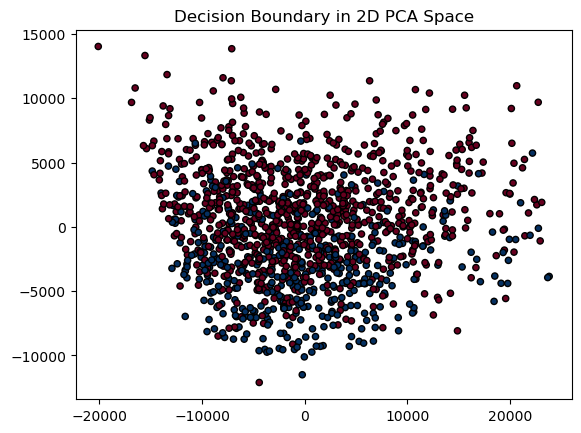

In [34]:
# Reduce dimensionality for visualization (2D)
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train)

# Fit SVM on reduced data
clf_2d = SVC(kernel='rbf', class_weight='balanced')
clf_2d.fit(X_train_pca_2d, y_train)

# Create grid to evaluate model
xx, yy = np.meshgrid(np.linspace(-3, 3, 500),
                     np.linspace(-3, 3, 500))
Z = clf_2d.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 100), cmap='RdBu')
plt.scatter(X_train_pca_2d[:, 0], X_train_pca_2d[:, 1], c=y_train, s=20, cmap='RdBu', edgecolors='k')
plt.title("Decision Boundary in 2D PCA Space")
plt.show()



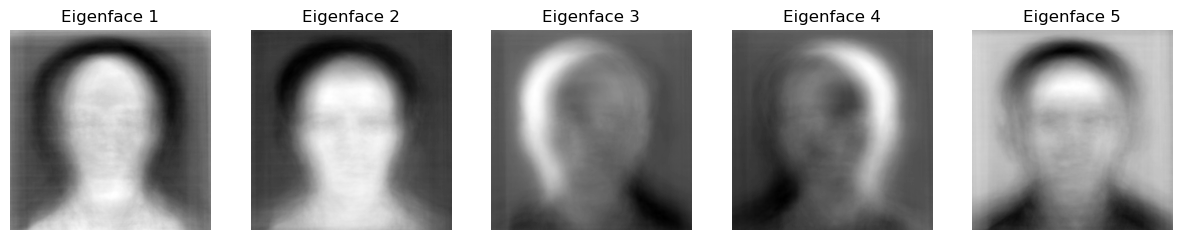

In [35]:
import matplotlib.pyplot as plt

# Assuming `pca` is your PCA object and has been fitted to your data
# Make sure the PCA object is fitted as shown in your earlier code snippet

# Reshape the components to match the original image shape, adjust accordingly
# Here, 255x255 is used based on your resize operation in the image loading function
eigenfaces = pca.components_.reshape((n_components, 255, 255))

# Display the first few eigenfaces
fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # Adjust subplot layout as needed
for i, ax in enumerate(axes.flat):
    ax.imshow(eigenfaces[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Eigenface {i+1}')
plt.show()


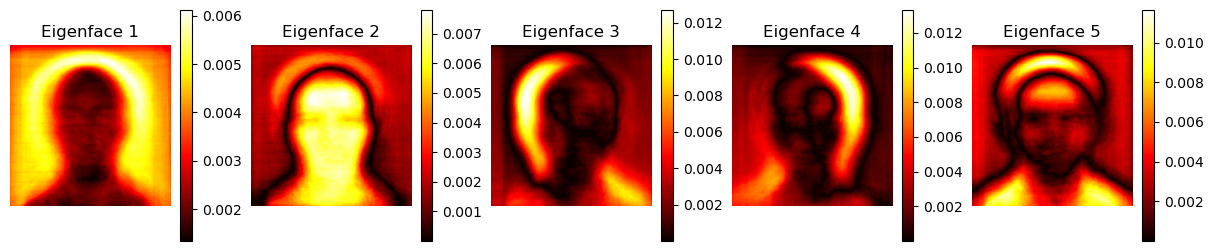

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `pca` is your PCA object and has been fitted to your data
# Reshape the components to match the original image shape, which is 255x255 in your case
eigenfaces = pca.components_.reshape((n_components, 255, 255))

# Display heatmaps for the first few eigenfaces
fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # Adjust subplot layout as needed
for i, ax in enumerate(axes.flat):
    heatmap = ax.imshow(np.abs(eigenfaces[i]), cmap='hot')
    ax.axis('off')
    ax.set_title(f'Eigenface {i+1}')
    fig.colorbar(heatmap, ax=ax)  # Add a colorbar to each subplot

plt.show()


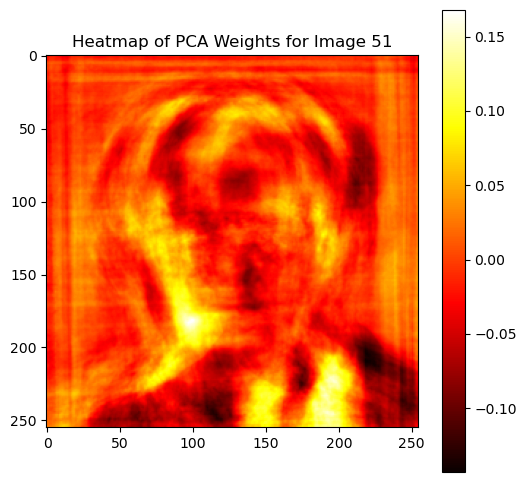

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `pca` is your PCA object and `images` contains your flattened images
# Let's take the first image in your dataset for demonstration
image_index = 50  # Change this index to visualize different images
image = images[image_index]

# Project the image onto the PCA components
image_pca_projection = pca.transform(image.reshape(1, -1))

# Each component's contribution to reconstructing the image
reconstruction_from_each_component = np.dot(image_pca_projection, pca.components_)

# Reshape for visualization
reconstruction_image = reconstruction_from_each_component.reshape(255, 255)

# Plotting the reconstruction weights as a heatmap
plt.figure(figsize=(6, 6))
plt.imshow(reconstruction_image, cmap='hot')
plt.colorbar()
plt.title(f"Heatmap of PCA Weights for Image {image_index + 1}")
plt.show()
